In [1]:
pip install PyPDF2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install python-docx  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox, scrolledtext
import PyPDF2
import docx
import re
import os
from collections import Counter
import json
from datetime import datetime
import threading

In [ ]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox, scrolledtext
import PyPDF2
import docx
import re
import os
from collections import Counter
import json
from datetime import datetime
import threading

class ResumeScreener:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Resume Screener Application")
        self.root.geometry("1000x700")
        self.root.configure(bg='#f0f0f0')
        
        # Data storage
        self.job_requirements = {}
        self.screened_resumes = []
        self.current_resume_text = ""
        
        # Create GUI
        self.create_widgets()
        
    def create_widgets(self):
        # Main frame with notebook for tabs
        main_frame = ttk.Frame(self.root)
        main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Create notebook for tabs
        notebook = ttk.Notebook(main_frame)
        notebook.pack(fill=tk.BOTH, expand=True)
        
        # Tab 1: Job Requirements Setup
        self.setup_tab = ttk.Frame(notebook)
        notebook.add(self.setup_tab, text="Job Requirements")
        self.create_setup_tab()
        
        # Tab 2: Resume Upload and Screening
        self.screening_tab = ttk.Frame(notebook)
        notebook.add(self.screening_tab, text="Resume Screening")
        self.create_screening_tab()
        
        # Tab 3: Results and Analytics
        self.results_tab = ttk.Frame(notebook)
        notebook.add(self.results_tab, text="Results & Analytics")
        self.create_results_tab()
        
    def create_setup_tab(self):
        # Job Title
        title_frame = ttk.LabelFrame(self.setup_tab, text="Job Information", padding=10)
        title_frame.pack(fill=tk.X, padx=10, pady=5)
        
        ttk.Label(title_frame, text="Job Title:").grid(row=0, column=0, sticky=tk.W, pady=2)
        self.job_title_var = tk.StringVar()
        ttk.Entry(title_frame, textvariable=self.job_title_var, width=50).grid(row=0, column=1, padx=10, pady=2)
        
        # Required Skills
        skills_frame = ttk.LabelFrame(self.setup_tab, text="Required Skills", padding=10)
        skills_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=5)
        
        ttk.Label(skills_frame, text="Required Skills (one per line):").pack(anchor=tk.W)
        self.skills_text = scrolledtext.ScrolledText(skills_frame, height=8, width=60)
        self.skills_text.pack(fill=tk.BOTH, expand=True, pady=5)
        
        # Experience Requirements
        exp_frame = ttk.LabelFrame(self.setup_tab, text="Experience Requirements", padding=10)
        exp_frame.pack(fill=tk.X, padx=10, pady=5)
        
        ttk.Label(exp_frame, text="Minimum Years of Experience:").grid(row=0, column=0, sticky=tk.W, pady=2)
        self.min_exp_var = tk.StringVar(value="0")
        ttk.Entry(exp_frame, textvariable=self.min_exp_var, width=10).grid(row=0, column=1, padx=10, pady=2)
        
        ttk.Label(exp_frame, text="Required Education Level:").grid(row=1, column=0, sticky=tk.W, pady=2)
        self.education_var = tk.StringVar()
        education_combo = ttk.Combobox(exp_frame, textvariable=self.education_var, 
                                     values=["High School", "Associate", "Bachelor", "Master", "PhD"])
        education_combo.grid(row=1, column=1, padx=10, pady=2)
        
        # Keywords and Weights
        keywords_frame = ttk.LabelFrame(self.setup_tab, text="Keywords & Weights", padding=10)
        keywords_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=5)
        
        ttk.Label(keywords_frame, text="Important Keywords (keyword:weight, one per line):").pack(anchor=tk.W)
        self.keywords_text = scrolledtext.ScrolledText(keywords_frame, height=6, width=60)
        self.keywords_text.pack(fill=tk.BOTH, expand=True, pady=5)
        
        # Save Requirements Button
        ttk.Button(self.setup_tab, text="Save Job Requirements", 
                  command=self.save_requirements).pack(pady=10)
        
    def create_screening_tab(self):
        # File Upload Section
        upload_frame = ttk.LabelFrame(self.screening_tab, text="Upload Resume", padding=10)
        upload_frame.pack(fill=tk.X, padx=10, pady=5)
        
        ttk.Button(upload_frame, text="Select Resume File", 
                  command=self.upload_resume).pack(side=tk.LEFT, padx=5)
        
        self.file_path_var = tk.StringVar()
        ttk.Label(upload_frame, textvariable=self.file_path_var).pack(side=tk.LEFT, padx=10)
        
        ttk.Button(upload_frame, text="Screen Resume", 
                  command=self.screen_resume).pack(side=tk.RIGHT, padx=5)
        
        # Resume Preview
        preview_frame = ttk.LabelFrame(self.screening_tab, text="Resume Preview", padding=10)
        preview_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=5)
        
        self.resume_preview = scrolledtext.ScrolledText(preview_frame, height=15)
        self.resume_preview.pack(fill=tk.BOTH, expand=True)
        
        # Screening Results
        results_frame = ttk.LabelFrame(self.screening_tab, text="Screening Results", padding=10)
        results_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=5)
        
        self.results_text = scrolledtext.ScrolledText(results_frame, height=8)
        self.results_text.pack(fill=tk.BOTH, expand=True)
        
    def create_results_tab(self):
        # Summary Statistics
        stats_frame = ttk.LabelFrame(self.results_tab, text="Screening Statistics", padding=10)
        stats_frame.pack(fill=tk.X, padx=10, pady=5)
        
        self.stats_text = tk.Text(stats_frame, height=6, width=80)
        self.stats_text.pack(fill=tk.X, pady=5)
        
        # Screened Resumes List
        list_frame = ttk.LabelFrame(self.results_tab, text="Screened Resumes", padding=10)
        list_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=5)
        
        # Treeview for resume list
        columns = ('Name', 'Score', 'Status', 'Date')
        self.resume_tree = ttk.Treeview(list_frame, columns=columns, show='headings', height=10)
        
        for col in columns:
            self.resume_tree.heading(col, text=col)
            self.resume_tree.column(col, width=150)
        
        scrollbar = ttk.Scrollbar(list_frame, orient=tk.VERTICAL, command=self.resume_tree.yview)
        self.resume_tree.configure(yscrollcommand=scrollbar.set)
        
        self.resume_tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        
        # Action Buttons
        button_frame = ttk.Frame(self.results_tab)
        button_frame.pack(fill=tk.X, padx=10, pady=5)
        
        ttk.Button(button_frame, text="Export Results", 
                  command=self.export_results).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Clear All Results", 
                  command=self.clear_results).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Refresh Stats", 
                  command=self.update_statistics).pack(side=tk.LEFT, padx=5)
        
    def save_requirements(self):
        try:
            self.job_requirements = {
                'job_title': self.job_title_var.get(),
                'required_skills': [skill.strip() for skill in self.skills_text.get(1.0, tk.END).split('\n') if skill.strip()],
                'min_experience': int(self.min_exp_var.get()) if self.min_exp_var.get() else 0,
                'education_level': self.education_var.get(),
                'keywords': self.parse_keywords(self.keywords_text.get(1.0, tk.END))
            }
            messagebox.showinfo("Success", "Job requirements saved successfully!")
        except Exception as e:
            messagebox.showerror("Error", f"Error saving requirements: {str(e)}")
    
    def parse_keywords(self, keywords_text):
        keywords = {}
        for line in keywords_text.split('\n'):
            if ':' in line:
                try:
                    keyword, weight = line.split(':', 1)
                    keywords[keyword.strip().lower()] = float(weight.strip())
                except ValueError:
                    continue
            elif line.strip():
                keywords[line.strip().lower()] = 1.0
        return keywords
    
    def upload_resume(self):
        file_path = filedialog.askopenfilename(
            title="Select Resume",
            filetypes=[("PDF files", "*.pdf"), ("Word files", "*.docx"), ("Text files", "*.txt")]
        )
        
        if file_path:
            self.file_path_var.set(os.path.basename(file_path))
            self.current_file_path = file_path
            
            # Extract and preview resume text
            self.current_resume_text = self.extract_text_from_file(file_path)
            self.resume_preview.delete(1.0, tk.END)
            self.resume_preview.insert(1.0, self.current_resume_text[:2000] + "..." if len(self.current_resume_text) > 2000 else self.current_resume_text)
    
    def extract_text_from_file(self, file_path):
        text = ""
        try:
            if file_path.lower().endswith('.pdf'):
                with open(file_path, 'rb') as file:
                    pdf_reader = PyPDF2.PdfReader(file)
                    for page in pdf_reader.pages:
                        text += page.extract_text() + "\n"
            
            elif file_path.lower().endswith('.docx'):
                doc = docx.Document(file_path)
                for paragraph in doc.paragraphs:
                    text += paragraph.text + "\n"
            
            elif file_path.lower().endswith('.txt'):
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                    
        except Exception as e:
            messagebox.showerror("Error", f"Error reading file: {str(e)}")
            
        return text
    
    def screen_resume(self):
        if not self.job_requirements:
            messagebox.showwarning("Warning", "Please set up job requirements first!")
            return
        
        if not self.current_resume_text:
            messagebox.showwarning("Warning", "Please upload a resume first!")
            return
        
        # Start screening in a separate thread to prevent UI freezing
        threading.Thread(target=self.perform_screening, daemon=True).start()
    
    def perform_screening(self):
        try:
            # Analyze resume
            analysis = self.analyze_resume(self.current_resume_text)
            
            # Calculate score
            score = self.calculate_score(analysis)
            
            # Determine status
            status = self.determine_status(score)
            
            # Update UI in main thread
            self.root.after(0, self.display_screening_results, analysis, score, status)
            
        except Exception as e:
            self.root.after(0, lambda: messagebox.showerror("Error", f"Error during screening: {str(e)}"))
    
    def analyze_resume(self, resume_text):
        resume_lower = resume_text.lower()
        
        analysis = {
            'skills_found': [],
            'skills_missing': [],
            'experience_years': self.extract_experience(resume_text),
            'education_level': self.extract_education(resume_text),
            'keyword_matches': {},
            'contact_info': self.extract_contact_info(resume_text)
        }
        
        # Check required skills
        for skill in self.job_requirements['required_skills']:
            if skill.lower() in resume_lower:
                analysis['skills_found'].append(skill)
            else:
                analysis['skills_missing'].append(skill)
        
        # Check keywords
        for keyword, weight in self.job_requirements['keywords'].items():
            count = resume_lower.count(keyword.lower())
            if count > 0:
                analysis['keyword_matches'][keyword] = count
        
        return analysis
    
    def extract_experience(self, text):
        # Simple regex patterns to find experience
        patterns = [
            r'(\d+)\s*(?:\+)?\s*years?\s*(?:of\s*)?experience',
            r'experience\s*(?:of\s*)?(\d+)\s*(?:\+)?\s*years?',
            r'(\d+)\s*(?:\+)?\s*yrs?\s*(?:of\s*)?(?:experience|exp)'
        ]
        
        years = []
        for pattern in patterns:
            matches = re.findall(pattern, text.lower())
            years.extend([int(match) for match in matches])
        
        return max(years) if years else 0
    
    def extract_education(self, text):
        education_keywords = {
            'phd': ['phd', 'ph.d', 'doctorate', 'doctoral'],
            'master': ['master', 'mba', 'ms', 'm.s', 'ma', 'm.a'],
            'bachelor': ['bachelor', 'bs', 'b.s', 'ba', 'b.a', 'be', 'b.e'],
            'associate': ['associate', 'as', 'a.s'],
            'high school': ['high school', 'diploma', 'ged']
        }
        
        text_lower = text.lower()
        
        for level, keywords in education_keywords.items():
            for keyword in keywords:
                if keyword in text_lower:
                    return level.title()
        
        return "Not Specified"
    
    def extract_contact_info(self, text):
        contact = {}
        
        # Email
        email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        emails = re.findall(email_pattern, text)
        contact['email'] = emails[0] if emails else "Not found"
        
        # Phone
        phone_pattern = r'[\+]?[1-9]?[\d\s\-\(\)]{10,}'
        phones = re.findall(phone_pattern, text)
        contact['phone'] = phones[0] if phones else "Not found"
        
        return contact
    
    def calculate_score(self, analysis):
        score = 0
        max_score = 0
        
        # Skills scoring (40% of total)
        skills_weight = 40
        if self.job_requirements['required_skills']:
            skills_match_ratio = len(analysis['skills_found']) / len(self.job_requirements['required_skills'])
            score += skills_match_ratio * skills_weight
        max_score += skills_weight
        
        # Experience scoring (30% of total)
        exp_weight = 30
        if analysis['experience_years'] >= self.job_requirements['min_experience']:
            score += exp_weight
        else:
            # Partial credit for some experience
            ratio = analysis['experience_years'] / max(self.job_requirements['min_experience'], 1)
            score += ratio * exp_weight * 0.7
        max_score += exp_weight
        
        # Keywords scoring (30% of total)
        keyword_weight = 30
        if self.job_requirements['keywords']:
            keyword_score = 0
            total_weight = sum(self.job_requirements['keywords'].values())
            
            for keyword, weight in self.job_requirements['keywords'].items():
                if keyword in analysis['keyword_matches']:
                    # Score based on frequency and weight
                    frequency_score = min(analysis['keyword_matches'][keyword] / 3, 1)  # Cap at 3 mentions
                    keyword_score += (weight / total_weight) * frequency_score * keyword_weight
            
            score += keyword_score
        max_score += keyword_weight
        
        return min(score / max_score * 100, 100)  # Convert to percentage and cap at 100
    
    def determine_status(self, score):
        if score >= 80:
            return "Highly Recommended"
        elif score >= 60:
            return "Recommended"
        elif score >= 40:
            return "Consider"
        else:
            return "Not Recommended"
    
    def display_screening_results(self, analysis, score, status):
        # Clear previous results
        self.results_text.delete(1.0, tk.END)
        
        # Display results
        results = f"""
SCREENING RESULTS
=================

Overall Score: {score:.1f}/100
Status: {status}

SKILLS ANALYSIS:
✓ Skills Found ({len(analysis['skills_found'])}): {', '.join(analysis['skills_found'])}
✗ Skills Missing ({len(analysis['skills_missing'])}): {', '.join(analysis['skills_missing'])}

EXPERIENCE:
Years of Experience: {analysis['experience_years']}
Required: {self.job_requirements['min_experience']}
Status: {'✓ Meets Requirement' if analysis['experience_years'] >= self.job_requirements['min_experience'] else '✗ Below Requirement'}

EDUCATION:
Found: {analysis['education_level']}
Required: {self.job_requirements.get('education_level', 'Not specified')}

KEYWORD MATCHES:
{chr(10).join([f"'{keyword}': {count} times" for keyword, count in analysis['keyword_matches'].items()])}

CONTACT INFORMATION:
Email: {analysis['contact_info']['email']}
Phone: {analysis['contact_info']['phone']}
"""
        
        self.results_text.insert(1.0, results)
        
        # Store results
        resume_data = {
            'filename': self.file_path_var.get(),
            'score': score,
            'status': status,
            'date': datetime.now().strftime("%Y-%m-%d %H:%M"),
            'analysis': analysis
        }
        
        self.screened_resumes.append(resume_data)
        
        # Update results tab
        self.update_resume_list()
        self.update_statistics()
    
    def update_resume_list(self):
        # Clear existing items
        for item in self.resume_tree.get_children():
            self.resume_tree.delete(item)
        
        # Add new items
        for resume in self.screened_resumes:
            self.resume_tree.insert('', 'end', values=(
                resume['filename'],
                f"{resume['score']:.1f}",
                resume['status'],
                resume['date']
            ))
    
    def update_statistics(self):
        if not self.screened_resumes:
            self.stats_text.delete(1.0, tk.END)
            self.stats_text.insert(1.0, "No resumes screened yet.")
            return
        
        total_resumes = len(self.screened_resumes)
        avg_score = sum(r['score'] for r in self.screened_resumes) / total_resumes
        
        status_counts = Counter(r['status'] for r in self.screened_resumes)
        
        stats = f"""SCREENING STATISTICS
=====================

Total Resumes Screened: {total_resumes}
Average Score: {avg_score:.1f}

Status Distribution:
{chr(10).join([f"  {status}: {count} ({count/total_resumes*100:.1f}%)" for status, count in status_counts.items()])}

Top Scoring Resume: {max(self.screened_resumes, key=lambda x: x['score'])['filename']} ({max(r['score'] for r in self.screened_resumes):.1f})
Lowest Scoring Resume: {min(self.screened_resumes, key=lambda x: x['score'])['filename']} ({min(r['score'] for r in self.screened_resumes):.1f})
"""
        
        self.stats_text.delete(1.0, tk.END)
        self.stats_text.insert(1.0, stats)
    
    def export_results(self):
        if not self.screened_resumes:
            messagebox.showwarning("Warning", "No results to export!")
            return
        
        file_path = filedialog.asksaveasfilename(
            defaultextension=".json",
            filetypes=[("JSON files", "*.json"), ("Text files", "*.txt")]
        )
        
        if file_path:
            try:
                with open(file_path, 'w') as f:
                    json.dump({
                        'job_requirements': self.job_requirements,
                        'screened_resumes': self.screened_resumes,
                        'export_date': datetime.now().isoformat()
                    }, f, indent=2)
                messagebox.showinfo("Success", f"Results exported to {file_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Error exporting results: {str(e)}")
    
    def clear_results(self):
        if messagebox.askyesno("Confirm", "Are you sure you want to clear all results?"):
            self.screened_resumes.clear()
            self.update_resume_list()
            self.update_statistics()
            messagebox.showinfo("Success", "All results cleared!")
    
    def run(self):
        self.root.mainloop()

# Main application
if __name__ == "__main__":
    app = ResumeScreener()
    app.run()

In [ ]:



# 2. Array Indexing and Slicing


# 3. Broadcasting Practice

# Explanation: a1 (1D) is "broadcast" to every row of a2 (2D).

# 4. DataFrame Creation and Summary

# 5. Data Cleaning


# 6. Data Filtering and Sorting


# 7. Basic Statistical Tests
# Dummy test scores for two classes


# 8. Linear Regression
# Sample regression data


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
arr = np.random.randint(10, 101, size=(3, 4))
print("3x4 Random Array:\n", arr)
print("Mean:", arr.mean())
print("Std Deviation:", arr.std())
print("Row-wise max:", arr.max(axis=1))
print("Column-wise max:", arr.max(axis=0))

3x4 Random Array:
 [[83 17 97 49]
 [14 97 16 26]
 [36 90 39 92]]
Mean: 54.666666666666664
Std Deviation: 32.97052555776986
Row-wise max: [97 97 92]
Column-wise max: [83 97 97 92]


In [3]:
arr2 = np.arange(1, 21).reshape(4, 5)
print("\nArray for slicing:\n", arr2)
print("Second row:", arr2[1])
print("Last two columns of each row:\n", arr2[:, -2:])
print("All even numbers:", arr2[arr2 % 2 == 0])


Array for slicing:
 [[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]
Second row: [ 6  7  8  9 10]
Last two columns of each row:
 [[ 4  5]
 [ 9 10]
 [14 15]
 [19 20]]
All even numbers: [ 2  4  6  8 10 12 14 16 18 20]


In [ ]:
a1 = np.array([10, 20, 30, 40])
a2 = np.ones((3, 4))
print("\nBroadcasting:\n", a2 + a1)


Broadcasting:
 [[11. 21. 31. 41.]
 [11. 21. 31. 41.]
 [11. 21. 31. 41.]]


In [5]:
data = {
    "Name": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "Age": [25, 38, 29, 45, 31],
    "Salary": [60000, 52000, 75000, 88000, 61000],
    "Department": ["IT", "HR", "IT", "Finance", "HR"]
}
df = pd.DataFrame(data)
print("\nDataFrame:\n", df)
print("Describe():\n", df.describe())
print("Group by Department (Avg Salary):\n", df.groupby("Department")["Salary"].mean())



DataFrame:
       Name  Age  Salary Department
0    Alice   25   60000         IT
1      Bob   38   52000         HR
2  Charlie   29   75000         IT
3    David   45   88000    Finance
4      Eve   31   61000         HR
Describe():
              Age        Salary
count   5.000000      5.000000
mean   33.600000  67200.000000
std     7.924645  14272.350893
min    25.000000  52000.000000
25%    29.000000  60000.000000
50%    31.000000  61000.000000
75%    38.000000  75000.000000
max    45.000000  88000.000000
Group by Department (Avg Salary):
 Department
Finance    88000.0
HR         56500.0
IT         67500.0
Name: Salary, dtype: float64


In [6]:
df2 = pd.DataFrame({
    "Name": ["Frank", None, "Grace", None, "Hannah"],
    "Age": [35, 42, np.nan, 28, 33],
    "Salary": [70000, 50000, 62000, np.nan, 68000]
})
print("\nBefore Cleaning:\n", df2)
# Fill NaN in 'Age' & 'Salary' with column mean
df2['Age'].fillna(df2['Age'].mean(), inplace=True)
df2['Salary'].fillna(df2['Salary'].mean(), inplace=True)
# Drop rows where Name is missing
df2.dropna(subset=['Name'], inplace=True)
print("After Cleaning:\n", df2)


Before Cleaning:
      Name   Age   Salary
0   Frank  35.0  70000.0
1    None  42.0  50000.0
2   Grace   NaN  62000.0
3    None  28.0      NaN
4  Hannah  33.0  68000.0
After Cleaning:
      Name   Age   Salary
0   Frank  35.0  70000.0
2   Grace  34.5  62000.0
4  Hannah  33.0  68000.0


C:\Users\Harsh\AppData\Local\Temp\ipykernel_30968\1068270600.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['Age'].fillna(df2['Age'].mean(), inplace=True)
C:\Users\Harsh\AppData\Local\Temp\ipykernel_30968\1068270600.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [7]:
filtered = df[(df['Age'] > 30) & (df['Salary'] > 50000)]
sorted_df = df.sort_values('Salary', ascending=False)
print("\nFiltered (Age>30 & Salary>50k):\n", filtered)
print("Sorted by Salary (desc):\n", sorted_df)


Filtered (Age>30 & Salary>50k):
     Name  Age  Salary Department
1    Bob   38   52000         HR
3  David   45   88000    Finance
4    Eve   31   61000         HR
Sorted by Salary (desc):
       Name  Age  Salary Department
3    David   45   88000    Finance
2  Charlie   29   75000         IT
4      Eve   31   61000         HR
0    Alice   25   60000         IT
1      Bob   38   52000         HR


In [8]:
scores_class1 = [85, 90, 78, 92, 88]
scores_class2 = [80, 84, 79, 85, 90]
t_stat, p_value = stats.ttest_ind(scores_class1, scores_class2)
print("\nT-test Results: t-statistic = {:.3f}, p-value = {:.3f}".format(t_stat, p_value))
# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is NO significant difference between the two groups.")


T-test Results: t-statistic = 0.957, p-value = 0.366
There is NO significant difference between the two groups.



Linear Regression: Salary vs Experience
Slope: 5000.0
Intercept: 34142.857142857145
R-squared: 0.9819639278557115
p-value: 1.4929727627271512e-05


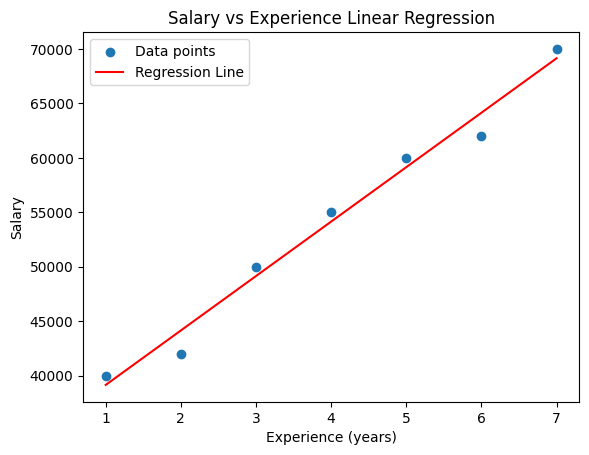

In [9]:
exp = np.array([1, 2, 3, 4, 5, 6, 7])
sal = np.array([40000, 42000, 50000, 55000, 60000, 62000, 70000])
slope, intercept, r_value, p_value, std_err = stats.linregress(exp, sal)
print("\nLinear Regression: Salary vs Experience")
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("p-value:", p_value)
# (Optional Plot)
plt.scatter(exp, sal, label="Data points")
plt.plot(exp, slope*exp+intercept, color="red", label="Regression Line")
plt.xlabel("Experience (years)")
plt.ylabel("Salary")
plt.legend()
plt.title("Salary vs Experience Linear Regression")
plt.show()


In [1]:
print("Hello damda ji ")

Hello damda ji 
